### Figure 3
 - Explained variance each subject individually
 

In [16]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.extend(['/home/nkinsky/Documents/GitHub/NeuroPy'])
sys.path.extend(['/home/nkinsky/Documents/GitHubPrivate/pythonprogs/DataPaths/'])
    
import numpy as np
    
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import subjects
from subjects import sns_boxplot_kw, stat_kw
from neuropy import plotting
from statannotations.Annotator import Annotator
from itertools import chain

from neuropy.plotting import plot_epochs
from neuropy.core import Epoch
from hfuncs import merge_quiet_wake

# For EV plots
full_session_names = [
        ["RatKDay1", "RatKDay2"],
        ["RatNDay1", "RatNDay2"],
        ["RatSDay2", "RatSDay3"],
        ["RatUDay1", "RatUDay2", "RatUDay4"],
        ["RatVDay1", "RatVDay2", "RatVDay3"],
        # "RatRDay1",
        ["RatRDay2"]
    ]
session_names_flat = list(chain.from_iterable(full_session_names))

# For slow oscillation / delta hypnograms
full_session_names_slow = [
        ["RatKDay1", "RatKDay2"],
        ["RatNDay1", "RatNDay2"],
        ["RatSDay2", "RatSDay3"],
        ["RatUDay1", "RatUDay2", "RatUDay4"],
        ["RatVDay1", "RatVDay2", "RatVDay3"],
        ["RatRDay1", "RatRDay2"],
        ["RatJDay1", "RatJDay2"],
    ]
session_names_flat_slow = list(chain.from_iterable(full_session_names_slow))

sessions = subjects.pf_sess()
grpdata = subjects.GroupData()
group = ["NSD", "SD"]

ev_states = grpdata.ev_brainstates
osc_states = grpdata.oscillation_brainstates
ev_df = grpdata.ev_pooled
ev_bool = ev_df.name.isin(session_names_flat)
ev_df = ev_df[ev_bool]
# ev_df["ev_diff"] = ev_df["ev"] - ev_df["rev"]
ev_pooled = grpdata.ev_in_chunks

# Note weird dimensions are to match previous plots
fig = plotting.Fig(
    12, 6, size=(6.615, 4.739), fontsize=5, constrained_layout=False, axis_lw=0.8, tick_size=2
)
filename = subjects.figpath_sd / "figure3"
caption = "Figure 3: MAZE reactivation during POST. \n(A) Explained variance (EV) in POST for each session of SD (orange) and NSD (purple) group with chance levels (gray). Error bars indicate +/- stdev. \n(B) Mean explained variance pooled across SD and NSD sessions. Error bars indicate +/- SEM."

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
#Sessions = 13


<Figure size 661.5x473.9 with 0 Axes>

In [2]:
def flatten(list_in):
    """Flatten a ragged list of different sized lists into one continuous list. List."""
    return list(chain.from_iterable(list_in))

#### Bin brainstates into 30 second bins

In [3]:
bin_size = 30/3600 # seconds
states_bin_all = []
for name in ev_states.name.unique():
    sesh_state_df = ev_states[ev_states.name == name]
    sesh_state_epochs = Epoch(epochs=sesh_state_df)
    sesh_state_rs = sesh_state_epochs.resample_labeled_epochs(bin_size, merge_neighbors=True)
    subvars = sesh_state_df["sub"].unique()
    grps = sesh_state_df["grp"].unique()
    assert (len(subvars) == 1) and (len(grps) == 1)
    states_bin_all.append(pd.DataFrame({"start": sesh_state_rs.starts, "stop": sesh_state_rs.stops, "label": sesh_state_rs.labels,
                                        "sub": subvars[0], "name": name, "grp": grps[0]}))

states_df_rs = pd.concat(states_bin_all)
states_df_rs

,start,stop,label,sub,name,grp
0,0.053688,0.087021,QW,0,RatKDay2,NSD
1,0.087021,0.195355,AW,0,RatKDay2,NSD
2,0.195355,0.212021,QW,0,RatKDay2,NSD
3,0.212021,0.220355,AW,0,RatKDay2,NSD
4,0.220355,0.253688,QW,0,RatKDay2,NSD
...,...,...,...,...,...,...
262,8.792008,8.858675,REM,12,RatRDay2,SD
263,8.858675,8.867008,AW,12,RatRDay2,SD
264,8.867008,8.883675,QW,12,RatRDay2,SD
265,8.883675,8.925341,NREM,12,RatRDay2,SD


### Plot Individual EVs
Original plot had QW and AW merged. Below code enables keeping them split and using a longer resolution (30 sec bins) to aid in visualization.

In [ ]:
from neuropy.plotting import plot_epochs
from neuropy.core import Epoch
from hfuncs import merge_quiet_wake

merge_wake = False
labels_order = ["NREM", "REM", "WK"] if merge_wake else ["NREM", "REM", "QW", "AW"]
resample_state = True
rs_append = f"_{int(bin_size*3600)}secstatebin" if resample_state else ""
    

errorbar_kw = dict(alpha=0.5, linewidth=0, ec=None)
session_names = ev_df.name.unique()
# animal_names = [_[:4] for _ in session_names]
# animal_names = ["RatN", "RatS", "RatU", "RatV"]
animal_names = ["RatK", "RatN", "RatS", "RatU", "RatV", "RatR"]
abs_day_names = [["Day1", "Day3"], ["Day1", "Day3"], ["Day1", "Day3"], ["Day1", "Day3", "Day8"], ["Day1", "Day3"], ["Day6", "Day11"]]
animal_row = [[0, 0], [1, 1], [2, 2], [3, 3, 3], [4, 4, 4], [5]]
animal_col = [[0, 1], [0, 1], [0, 1], [0, 1, 2], [0, 1, 2], [1]]
ev_colors = subjects.colors_sd(1)

subfig = fig.fig.add_subfigure(fig.gs[:12, :6])
axs = subfig.subplots(
    12,
    3,
    sharey="row",
    sharex=True,
    gridspec_kw=dict(height_ratios=[1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4]),
)
# axs = axs.T.reshape(-1)


# for row, anim in enumerate(animal_names):
for sess, row, col, abs_day in zip(flatten(full_session_names), flatten(animal_row), flatten(animal_col), flatten(abs_day_names)):
    # anim_sessions = session_names_flat[[anim in _ for _ in session_names_flat]]
    # df_name = ev_df[ev_df.name.isin(anim_sessions)]
    # states_name = ev_states[ev_states.name.isin(anim_sessions)]
    # sex = df_name.sex.iloc[0]
    # grps_name = df_name.grp.unique()[::-1]

    # subfig = fig.fig.add_subfigure(fig.gs[row, :2])
    # axs = subfig.subplots(2, 2, sharey="row", gridspec_kw=dict(height_ratios=[1, 4]))
    # axs = axs.T.reshape(-1)

    # for i, sess in enumerate(anim_sessions):
    # states = states_name[states_name["name"] == sess]

    anim = sess[0:4]
    df_name = ev_df[ev_df["name"] == sess]
    sex = df_name.sex.iloc[0]
    grp = df_name.grp.unique()[0]
    if resample_state:
        states = states_df_rs[states_df_rs["name"] == sess]
        states = states[[label in labels_order for label in states.label]]
    else:
        states = ev_states[ev_states["name"] == sess]

    n_neurons = df_name["n_neurons"].unique()
    n_pairs = df_name["n_pairs"].unique()
    t, ev, ev_err, rev, rev_err = (
        df_name["zt"].astype(float),
        df_name["ev"],
        df_name["ev_std"],
        df_name["rev"],
        df_name["rev_std"],
    )

    ax_hypno = axs[2 * row, col]
    ax = axs[2 * row + 1, col]

     # epoch = Epoch(states).duration_slice(min_dur=120/3600)
    epoch = merge_quiet_wake(Epoch(states)) if merge_wake else states

    # Plot hypnogram
    sd_color = subjects.colors_sd(1)[1]
    rs_color = subjects.colors_rs(1)[0]
    colors = "k" if grp == "NSD" else {"SD": sd_color, "RS": rs_color}
    colorby = "label" if grp == "NSD" else "exp_stage"
    state_epoch = Epoch(epoch)
    if grp == "SD":

        # # Find exact stop time for SD
        # sid = np.where([sess == s.name for s in sessions])[0][0]
        # sd_stop = sessions[sid].get_zt_epochs()["2.5-5"].stops[0]/3600  # in hours
        
        exp_stage = np.ones_like(epoch.label.values)
        exp_stage[epoch.start < 5] = "SD"
        exp_stage[epoch.start > 5] = "RS"
        state_epoch = state_epoch.add_column("exp_stage", exp_stage)
    plot_epochs(
        state_epoch,
        ax=ax_hypno,
        labels_order=labels_order,
        colors=colors,
        colorby=colorby,
        # colors=k,
        collapsed=False,
    )
    
    ax_hypno.set_xlim([0, 8])
    ax_hypno.set_axis_off()

    # Previous code for plotting with QW/AW merged and no coloring.
    # epoch = Epoch(states).duration_slice(min_dur=120/3600)
    # epoch = merge_quiet_wake(Epoch(states)) if merge_wake else states
    # plot_epochs(
    #     epoch,
    #     ax=ax_hypno,
    #     labels_order=labels_order,
    #     colors="k",
    #     collapsed=False,
    # )
    # ax_hypno.set_xlim([0, 8])
    ax_hypno.set_axis_off()

    ax.fill_between(t, rev - rev_err, rev + rev_err, color="#63c56e", **errorbar_kw)
    ax.plot(t, rev, color="#63c56e")

    if grp == "NSD":
        color = ev_colors[0]
        ax.fill_between(t, ev - ev_err, ev + ev_err, color=color, **errorbar_kw)
        ax.plot(t, ev, color=color, lw=0.8)

    if grp == "SD":
        sd_color = ev_colors[1]
        sd_indx = t <= 5
        ax.fill_between(
            t[sd_indx],
            ev[sd_indx] - ev_err[sd_indx],
            ev[sd_indx] + ev_err[sd_indx],
            color=sd_color,
            **errorbar_kw,
        )
        ax.plot(t[sd_indx], ev[sd_indx], color=sd_color, lw=0.8)

        rs_color = "#5599FF"
        ax.fill_between(
            t[~sd_indx],
            ev[~sd_indx] - ev_err[~sd_indx],
            ev[~sd_indx] + ev_err[~sd_indx],
            color=rs_color,
            **errorbar_kw,
        )
        ax.plot(t[~sd_indx], ev[~sd_indx], color=rs_color, lw=0.8)
        if anim == "RatR":
            ax.set_ylim([0, 0.24])

    ax.text(
        0.4,
        0.8,
        f"{abs_day}: {n_neurons[0]} PN,{n_pairs[0]} pairs",
        fontdict=dict(fontsize=5),
        transform=ax.transAxes,
    )
    ax.set_xlim([0, 8])
    # ax.set_title(abs_day)

    # if name == "RatR":
    # ax.set_ylim(0, 0.25)

    sex_symbol = "$\u2640$" if sex == "female" else "$\u2642$"
    # sex_color = "#F50057" if sex == "female" else "#2962FF"
    # if i == 0:
    if col == 0:
        ax.set_ylabel(f"EV\n({anim} {sex_symbol})")
        # fig.legend(ax, [name + sex_symbol], color='k', x=-0.4, y=1)

    # ax.set_xticks([1, 3, 5, 7, 9])

# Turn off unused axes - manual is the easiest - why is this not working?
off_rows, off_cols = [0, 1, 2, 5, 5], [2, 2, 2, 0, 2]
for off_row, off_col in zip(off_rows, off_cols):
    ax_hypno = axs[2 * off_row, off_col]
    ax = axs[2 * off_row + 1, off_col]
    ax_hypno.set_axis_off()
    ax.set_axis_off()

fig.fig.figure

fig.savefig(subjects.figpath_sd / f"sd_extendedfig1_NRK{rs_append}", dpi=300, format="svg")

In [ ]:
# ax.plot((0, 8), (0, 0.1))
# ax.set_axis_off()
fig.fig.figure

In [ ]:
_, ax = plt.subplots()

ax.plot(np.correlate(ev, ev, "same"))

### Companion plot with spectogram + hypnogram for all animals

In [4]:
full_session_names_slow = [
        ["RatKDay1", "RatKDay2"],
        ["RatNDay1", "RatNDay2"],
        ["RatSDay2", "RatSDay3"],
        ["RatUDay1", "RatUDay2", "RatUDay4"],
        ["RatVDay1", "RatVDay2", "RatVDay3"],
        ["RatRDay1", "RatRDay2"],
        ["RatJDay1", "RatJDay2"],
    ]
session_names_flat_slow = list(chain.from_iterable(full_session_names_slow))

In [17]:
# Bin brainstates into 30 second bins
bin_size = 30/3600 # seconds
states_bin_all = []
for name in osc_states.name.unique():
    sesh_state_df = osc_states[osc_states.name == name]
    sesh_state_epochs = Epoch(epochs=sesh_state_df)
    sesh_state_rs = sesh_state_epochs.resample_labeled_epochs(bin_size, merge_neighbors=True)
    subvars = sesh_state_df["sub"].unique()
    grps = sesh_state_df["grp"].unique()
    assert (len(subvars) == 1) and (len(grps) == 1)
    states_bin_all.append(pd.DataFrame({"start": sesh_state_rs.starts, "stop": sesh_state_rs.stops, "label": sesh_state_rs.labels,
                                        "sub": subvars[0], "name": name, "grp": grps[0]}))

states_df_rs = pd.concat(states_bin_all)
states_df_rs

,start,stop,label,sub,name,grp
0,0.005906,0.022573,AW,0,RatJDay2,NSD
1,0.022573,0.030906,QW,0,RatJDay2,NSD
2,0.030906,0.039239,AW,0,RatJDay2,NSD
3,0.039239,0.047573,QW,0,RatJDay2,NSD
4,0.047573,0.114239,AW,0,RatJDay2,NSD
...,...,...,...,...,...,...
181,8.765354,8.840354,QW,15,RatVDay2,SD
182,8.840354,8.907021,NREM,15,RatVDay2,SD
183,8.907021,8.915354,REM,15,RatVDay2,SD
184,8.915354,8.932021,QW,15,RatVDay2,SD


In [18]:
states_df_rs.name.unique()

array(['RatJDay2', 'RatKDay2', 'RatNDay2', 'RatSDay2', 'RatRDay1',
       'RatUDay2', 'RatVDay1', 'RatVDay3', 'RatJDay1', 'RatKDay1',
       'RatNDay1', 'RatSDay3', 'RatRDay2', 'RatUDay1', 'RatUDay4',
       'RatVDay2'], dtype=object)

In [5]:
# Get signal for all rats! - takes a LOOONGG time to run, so debug thoughtfully!
from neuropy.core import Signal
from scipy.ndimage import gaussian_filter1d
from neuropy.utils import signal_process

smooth = lambda x: gaussian_filter1d(x, sigma=60 / 4)
# sessions = subjects.nsd.ratVday1 + subjects.sd.ratVday2
# sessions = subjects.nsd + subjects.sd
# session = subjects.pf_sess()

time_all, brainstates, spect_all = [], [], []
for sess_name in session_names_flat_slow:
    sname_fixed = subjects.sess_name_fix(sess_name)
    print(sess_name)  # cheap progress bar
    if sname_fixed in dir(subjects.nsd):
        sess = getattr(subjects.nsd, sname_fixed)[0]
    else:
        sess = getattr(subjects.sd, sname_fixed)[0]
    pre = sess.paradigm["pre"].flatten()
    maze = sess.paradigm["maze"].flatten()
    post = sess.paradigm["post"].flatten()
    t_start = pre[0]
    t_stop = post[0] + 8 * 3600

    # Chan 191 was used for ratUDay2 and ratUDay4
    # signal = sess.eegfile.get_signal(191, t_start=t_start, t_stop=t_stop)
    chan = sess.best_channels.slow_wave
    signal = sess.eegfile.get_signal(chan, t_start=t_start, t_stop=t_stop)
    trace = signal.traces[0].astype("int16")

    if sess.artifact is not None:
        for e in sess.artifact.as_array():
            indx = (signal.time >= e[0]) & (signal.time <= e[1])
            trace[indx] = 1e-16

    signal = Signal(trace[np.newaxis, :], sampling_rate=1250, t_start=signal.t_start)
    spect = signal_process.FourierSg(signal, window=4, overlap=0, norm_sig=False)
    sxx = spect.freq_slice(1.5, 10).traces

    post_indx = (spect.time >= post[0]) & (spect.time <= t_stop)
    time_all.append(spect.time[post_indx])
    spect_all.append(sxx[:, post_indx])

    brainstates.append(sess.brainstates.time_slice(t_start, t_stop))

RatKDay1
RatKDay2
RatNDay1
RatNDay2
RatSDay2
RatSDay3
RatUDay1
RatUDay2
RatUDay4
RatVDay1
RatVDay2
RatVDay3
RatRDay1
RatRDay2
RatJDay1
RatJDay2


In [8]:
if resample_state:
    states = states_df_rs[states_df_rs["name"] == sess]
    states = states[[label in labels_order for label in states.label]]
else:
    states = ev_states[ev_states["name"] == sess]
states

""


In [ ]:
sex = df_name.sex.iloc[0]
grp = df_name.grp.unique()[0]

In [23]:
df_name

,ev,ev_std,rev,rev_std,zt,n_neurons,n_pairs,sub,name,sex,grp


In [24]:
sess

'RatJDay2'

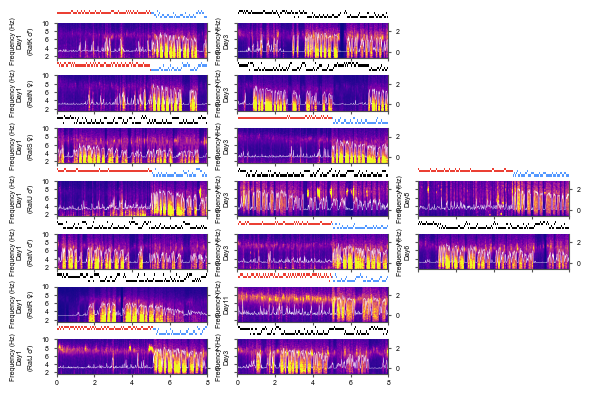

In [26]:
from neuropy.plotting import plot_epochs
from neuropy.core import Epoch, Neurons
from hfuncs import merge_quiet_wake

merge_wake = False
labels_order = ["NREM", "REM", "WK"] if merge_wake else ["NREM", "REM", "QW", "AW"]
resample_state = True
rs_append = f"_{int(bin_size*3600)}secstatebin" if resample_state else ""

dmax = 2  # sets max for delta rate (plotted on right axes) which range from 3 Hz to 8 Hz on left axis
    
errorbar_kw = dict(alpha=0.5, linewidth=0, ec=None)
session_names = ev_df.name.unique()
# animal_names = [_[:4] for _ in session_names]
# animal_names = ["RatN", "RatS", "RatU", "RatV"]
animal_names = ["RatK", "RatN", "RatS", "RatU", "RatV", "RatR", "RatJ"]
abs_day_names = [["Day1", "Day3"], ["Day1", "Day3"], ["Day1", "Day3"], ["Day1", "Day3", "Day8"], ["Day1", "Day3", "Day6"], ["Day1", "Day11"],
                 ["Day1", "Day3"]]
animal_row = [[0, 0], [1, 1], [2, 2], [3, 3, 3], [4, 4, 4], [5, 5], [6, 6]]
animal_col = [[0, 1], [0, 1], [0, 1], [0, 1, 2], [0, 1, 2], [0, 1], [0, 1]]
ev_colors = subjects.colors_sd(1)

# Note weird dimensions are to match previous plots
figs = plotting.Fig(
    12, 6, size=(6.615, 4.739), fontsize=5, constrained_layout=False, axis_lw=0.8, tick_size=2
)

subfig = figs.fig.add_subfigure(figs.gs[:14, :6])
axs = subfig.subplots(
    14,
    3,
    sharey="row",
    sharex=True,
    gridspec_kw=dict(height_ratios=[1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4]),
)
# axs = axs.T.reshape(-1)

lookup_df = pd.DataFrame({"name": ["RatRDay1", "RatJDay1", "RatJDay2"], "sex": ["female", "male", "male"], "grp": ["NSD", "SD", "NSD"]})

# for row, anim in enumerate(animal_names):
for ids, (sess, row, col, abs_day) in enumerate(zip(flatten(full_session_names_slow), flatten(animal_row), flatten(animal_col), 
                                                    flatten(abs_day_names))):

    anim = sess[0:4]
    df_name = ev_df[ev_df["name"] == sess]
    if sess not in ["RatRDay1", "RatJDay1", "RatJDay2"]:
        sex = df_name.sex.iloc[0]
        grp = df_name.grp.unique()[0]
        n_neurons = df_name["n_neurons"].unique()
        n_pairs = df_name["n_pairs"].unique()
        t, ev, ev_err, rev, rev_err = (
        df_name["zt"].astype(float),
        df_name["ev"],
        df_name["ev_std"],
        df_name["rev"],
        df_name["rev_std"],
    )
    else:
        sex = lookup_df[lookup_df.name == sess].sex.values[0]
        grp = lookup_df[lookup_df.name == sess].grp.values[0]
    if resample_state:
        states = states_df_rs[states_df_rs["name"] == sess]
        states = states[[label in labels_order for label in states.label]]
    else:
        states = ev_states[ev_states["name"] == sess]
    
    

    ax_hypno = axs[2 * row, col]
    ax = axs[2 * row + 1, col]

    # Grab delta wave epochs
    sname_fixed = subjects.sess_name_fix(sess)
    if sname_fixed in dir(subjects.nsd):
        delta_epochs = getattr(subjects.nsd, sname_fixed)[0].delta_wave
    else:
        delta_epochs = getattr(subjects.sd, sname_fixed)[0].delta_wave
    
    # epoch = Epoch(states).duration_slice(min_dur=120/3600)
    epoch = merge_quiet_wake(Epoch(states)) if merge_wake else states

    # Plot hypnogram
    sd_color = subjects.colors_sd(1)[1]
    rs_color = subjects.colors_rs(1)[0]
    colors = "k" if grp == "NSD" else {"SD": sd_color, "RS": rs_color}
    colorby = "label" if grp == "NSD" else "exp_stage"
    state_epoch = Epoch(epoch)
    if grp == "SD":
        exp_stage = np.ones_like(epoch.label.values)
        exp_stage[epoch.start < 5] = "SD"
        exp_stage[epoch.start > 5] = "RS"
        state_epoch = state_epoch.add_column("exp_stage", exp_stage)
    plot_epochs(
        state_epoch,
        ax=ax_hypno,
        labels_order=labels_order,
        colors=colors,
        colorby=colorby,
        # colors=k,
        collapsed=False,
    )
    
    ax_hypno.set_xlim([0, 8])
    ax_hypno.set_axis_off()

    # Plot Spectrograms
    
    # time = time_all[ids]
    time = time_all[ids]/3600  # convert to hours to match epochs time
    time0 = time[0]  # Save for adjustment to delta times later.
    time = time - time[0]  # set start time = zt0
    sxx = spect_all[ids]
    states = brainstates[ids]
    # post_t = np.arange(time[0], time[-1] + 10, 2.5 * 3600)
    # zt_time = np.round(((post_t - time[0]) / 3600), 2)
    post_t = np.arange(time[0], time[-1] + 10/3600, 2.5)
    zt_time = np.round(post_t - time[0], 2)

    ax.imshow(
        # sxx*100,
        stats.zscore(sxx, axis=None),
        aspect="auto",
        cmap="plasma",
        vmax=1.3,
        origin="lower",
        # extent=[time[0], time[-1], 1.5, 10],
        extent=[0, time[-1], 1.5, 10],  # zero times to
        # extent=[0, 8, 1.5, 10],
    )
    # ax.set_ylabel("Frequency (Hz)")
    ax.set_yticks([2, 4, 6, 8, 10])
    # axs[0,i].set_ylim(1.5,10)
    # ax.plot(time, theta_all[i]*100,'k')
    # ax.set_xticks(post_t, zt_time)

    # Overlay delta rate on spectrogram
    delta_starts = delta_epochs.starts/3600 - time0
    delta_binned = Neurons([delta_starts], t_stop=(delta_starts.max())).get_binned_spiketrains(bin_size=60/3600)
    # dmax = delta_binned.firing_rate.max()/3600
    rate2f = lambda r: 5 / dmax * (r + 3 * dmax / 5)
    axd = ax.secondary_yaxis('right', functions=(lambda f: dmax/5 * (f - 3), lambda r: 5 / dmax * (r + 3 * dmax / 5)))
    ax.plot(delta_binned.time, rate2f(delta_binned.firing_rate.squeeze()/3600), 'w', linewidth=0.25)
        
    sex_symbol = "$\u2640$" if sex == "female" else "$\u2642$"
    # sex_color = "#F50057" if sex == "female" else "#2962FF"
    # if i == 0:
    if col == 0:
        ax.set_ylabel(f"Frequency (Hz)\n{abs_day}\n({anim} {sex_symbol})")
    else:
        # ax.set_ylabel(
        # fig.legend(ax, [name + sex_symbol], color='k', x=-0.4, y=1)
        ax.set_ylabel(f"Frequency (Hz)\n{abs_day}")
    # ax.set_xticks([1, 3, 5, 7, 9])

# Turn off unused axes - manual is the easiest - why is this not working?
off_rows, off_cols = [0, 1, 2, 5, 6], [2, 2, 2, 2, 2]
for off_row, off_col in zip(off_rows, off_cols):
    ax_hypno = axs[2 * off_row, off_col]
    ax = axs[2 * off_row + 1, off_col]
    ax_hypno.set_axis_off()
    ax.set_axis_off()

figs.savefig(subjects.figpath_sd / f"sd_extendedfig1spectrogram_NRK{rs_append}", dpi=300, format="svg")

In [ ]:
# Check that secondary axis on spectrogram plots are working correctly
_, axcheck = plt.subplots(2, 1, figsize=(9, 3))
for ida, ax in enumerate(axcheck):
    ax.imshow(
            # sxx*100,
            stats.zscore(sxx, axis=None),
            aspect="auto",
            cmap="plasma",
            vmax=1.3,
            origin="lower",
            # extent=[time[0], time[-1], 1.5, 10],
            extent=[0, time[-1], 1.5, 10],  # zero times to
            # extent=[0, 8, 1.5, 10],
        )
    drate_fake = np.array((0, 2)) if ida == 0 else np.array((0, 10))
    dmax = drate_fake.max()
    print(dmax)
    # rate2f = lambda r: 5 / dmax * (r + 3 * dmax / 5)
    rate2f = lambda y: 5 / dmax * (y + 3 * dmax / 5)
    axd = ax.secondary_yaxis('right', functions=(lambda y: dmax/5 * (y - 3), 
                                                 rate2f))
                                                 #lambda r: 5 / dmax * (r + 3 * dmax / 5)))
    ax.plot([0, 8], rate2f(np.array((0, 2))), 'w', linewidth=0.25)
    print(rate2f(np.array((0, 2))))
    

In [ ]:
rate2f(dmax)

In [ ]:
_, ax = plt.subplots()
ax.imshow(
        # sxx*100,
        stats.zscore(sxx, axis=None),
        aspect="auto",
        cmap="plasma",
        vmax=1.3,
        origin="lower",
        extent=[time[0], time[-1], 1.5, 10],
        # # extent=[0, 8, 1.5, 10],
        # extent=[1000, 6000, 1.5, 10]
    )

### Pooled Evs

In [ ]:
ax = fig.subplot(fig.gs[:2, 4])
plot_kw = dict(data=ev_pooled, x="zt", y="ev_diff", hue="grp", hue_order=group, ax=ax)
# violinplot(**plot_kw)
sns.stripplot(
    **plot_kw,
    palette=subjects.colors_sd(),
    dodge=True,
    edgecolor="w",
    linewidth=0.4,
    size=2.6,
    jitter=0.2
)
sns.barplot(**plot_kw, facecolor="w", linewidth=0.5, edgecolor="0.2", ci=None)

ax.tick_params("x", rotation=30)
ax.set_ylabel("Explained variance diff")
ax.set_xlabel("")
ax.legend("", frameon=False)
# stats
orders = ev_pooled.zt.unique()
# pairs = [((_, "NSD"), (_, "SD")) for _ in orders]
pairs = [
    (("0-2.5", "NSD"), ("5-7.5", "SD")),
    (("0-2.5", "NSD"), ("0-2.5", "SD")),
]
annotator = Annotator(pairs=pairs, **plot_kw, order=orders)
annotator.configure(test="t-test_welch", **stat_kw)
# annotator.configure(
#     test=subjects.get_statannot_ranksum(),
#     **subjects.stat_kw,
#     color="k",
#     comparisons_correction=None
# )
annotator.apply_and_annotate()
annotator.reset_configuration()


pairs = [
    (("2.5-5", "SD"), ("5-7.5", "SD")),
]
annotator = Annotator(pairs=pairs, **plot_kw, order=orders)
annotator.configure(test="t-test_paired", **stat_kw)
annotator.apply_and_annotate()
annotator.reset_configuration()

In [ ]:
ev_pooled.groupby(["grp", "zt"], sort=False).describe()["ev_diff"]

In [ ]:
ev_pooled.groupby(["grp", "zt"], sort=False).sem()

In [ ]:
vals = ev_pooled[(ev_pooled.grp == "SD") & (ev_pooled.zt == "5-7.5")].ev_diff.values

stats.ttest_1samp(vals, 0)

### ANOVA

In [ ]:
import pingouin as pg

ev_pooled["name2"] = [s[:4] for s in ev_pooled["name"]]

In [ ]:
st = pg.mixed_anova(
    data=ev_pooled[(ev_pooled.zt != "PRE")],
    dv="ev_diff",
    within="zt",
    between="grp",
    subject="session",
)
pg.print_table(st)
posthocs = pg.pairwise_tests(
    dv="ev_diff",
    within="zt",
    between="grp",
    subject="session",
    data=ev_pooled[ev_pooled.zt != "PRE"],
)
pg.print_table(posthocs)

In [ ]:
from statsmodels.stats import anova


st = anova.AnovaRM(
    data=ev_pooled[(ev_pooled.zt != "PRE")],
    depvar="ev_diff",
    within=["zt", "grp"],
    subject="name2",
    aggregate_func=np.mean,
)
print(st.fit())

### saving

In [ ]:
# fig.savefig(filename)